In [4]:
# 사전 훈련된 모델 생성

from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

### 특성 추출 : 훈련된 합성곱층을 사용해 새로운 전결합층을 훈련하는것
1. 훈련된 합성곱층을 사용해 특징을 추출한 후, 전결합층 모델을 별도로 훈련.
> 데이터가 합성곱층을 맨 처음 특징을 추출하는 한번만 거치기 때문에 속도가 굉장히 빠르나, 데이터 증식을 사용하지 못함

2. 훈련된 합성곱층에 전결합층을 결합하여 엔드 투 엔드로 훈련.
> 데이터가 매번 합성곱층을 거쳐야 하기 때문에 속도가 느리지만, 데이터 증식을 사용하여 훈련할 수 있음

In [4]:
# 특성 추출 1-1 : 훈련된 합성곱층을 사용해 전결합층에 넣을 특징을 추출

import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = './datasets/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # 제너레이터는 루프 안에서 무한하게 데이터를 만들어내므로 모든 이미지를 한 번씩 처리하고 나면 중지합니다
            break
    return features, labels

# 특징 추출
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

print("feature extract finish")

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
feature extract finish


In [5]:
# data flatten

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

print("flatten finish")

flatten finish


In [9]:
# 특성 추출 1-2 : 결합층을 생성한 데이터로 훈련

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

print("training finish")

Epoch 1/30
100/100 [==============================] - 1s 11ms/step - loss: 0.6136 - acc: 0.6665 - val_loss: 0.4357 - val_acc: 0.8260
Epoch 2/30
100/100 [==============================] - 1s 10ms/step - loss: 0.4290 - acc: 0.7985 - val_loss: 0.3717 - val_acc: 0.8470
Epoch 3/30
100/100 [==============================] - 1s 10ms/step - loss: 0.3463 - acc: 0.8545 - val_loss: 0.3310 - val_acc: 0.8630
Epoch 4/30
100/100 [==============================] - 1s 10ms/step - loss: 0.3127 - acc: 0.8705 - val_loss: 0.3139 - val_acc: 0.8700
Epoch 5/30
100/100 [==============================] - 1s 10ms/step - loss: 0.2836 - acc: 0.8825 - val_loss: 0.3184 - val_acc: 0.8660
Epoch 6/30
100/100 [==============================] - 1s 10ms/step - loss: 0.2659 - acc: 0.9000 - val_loss: 0.2891 - val_acc: 0.8820
Epoch 7/30
100/100 [==============================] - 1s 10ms/step - loss: 0.2496 - acc: 0.9030 - val_loss: 0.2868 - val_acc: 0.8800
Epoch 8/30
100/100 [==============================] - 1s 10ms/step - 

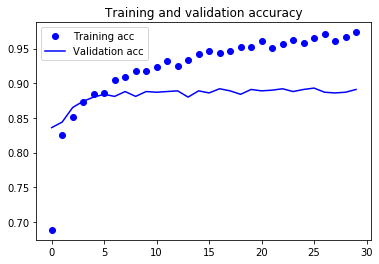

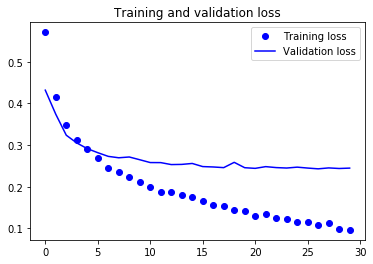

In [11]:
# 특성 추출 1-3 : 결과 그래프

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [7]:
# 특성 추출 2-1 : 합성곱층과 새로운 전결합층을 붙여서 새로 훈련(증식 사용)

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [8]:
# 특성 추출 2-2 : 학습 전에 합성곱층을 꼭 동결시키고 다시 컴파일 해야함
conv_base.trainable = False

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

In [9]:
# 특성 추출 2-3: 데이터 증식
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = './datasets/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지의 크기를 150 × 150로 변경합니다
        target_size=(150, 150),
        batch_size=20,
        # binary_crossentropy 손실을 사용하므로 이진 레이블이 필요합니다
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')



history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

model.save("cats_vs_dogs.h5")
print("training finish")

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
100/100 - 58s - loss: 0.5484 - acc: 0.7235 - val_loss: 0.4058 - val_acc: 0.8440
Epoch 2/10
100/100 - 63s - loss: 0.4064 - acc: 0.8405 - val_loss: 0.3339 - val_acc: 0.8680
Epoch 3/10
100/100 - 63s - loss: 0.3582 - acc: 0.8535 - val_loss: 0.3040 - val_acc: 0.8800
Epoch 4/10
100/100 - 63s - loss: 0.3369 - acc: 0.8530 - val_loss: 0.2873 - val_acc: 0.8840
Epoch 5/10
100/100 - 62s - loss: 0.3048 - acc: 0.8750 - val_loss: 0.2746 - val_acc: 0.8840
Epoch 6/10
100/100 - 63s - loss: 0.2851 - acc: 0.8790 - val_loss: 0.2604 - val_acc: 0.8880
Epoch 7/10
100/100 - 63s - loss: 0.2796 - acc: 0.8815 - val_loss: 0.2710 - val_acc: 0.8910
Epoch 8/10
100/100 - 63s - loss: 0.2614 - acc: 0.8920 - val_loss: 0.2468 - val_acc: 0.8970
Epoch 9/10
100/100 - 64s - loss: 0.2589 - acc: 0.8895 - val_loss: 0.2448 - val_acc: 0.8970
Epoch 10/10
100/100 -

In [ ]:
# 특성 추출 2-4 : 결과 그래프

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 파인튜닝 : 전결합층과 함께 합성곱층의 일부를 재훈련하는것

1. 사전 훈련된 기반 네트워크에 새로운 네트워크 추가
2. 기반 네트워크 동결 후 새로 추가한 네트워크 훈련
3. 기반 네트워크의 일부 층 동결 해제 후 새로 추가한 네트워크와 함께 훈련

- 일반적으로 상위 층에 있는 합성곱층을 재훈련하는데, 이는 하위 층들은 좀 더 일반적이고 재사용 가능한 특성을 인코딩하고, 상위 층들은 좀 더 훈련 데이터에 특화된 특성을 인코딩하기 때문




In [ ]:
# 파인튜닝 1 : block5_conv1을 포함한 상위 3개 층의 동결 해제

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
# 학습률을 낮춰서 재 컴파일 후 훈련.
# 학습률이 크면 이미 훈련된 네트워크에 손실이 생길 수 있음

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

In [ ]:
# 파인 튜닝 2: 결과 그래프

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# 그래프를 쉽게 보기 위해 지수 이동 평균 적용

def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# 테스트 데이터로 평가

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)